In [1]:
import pandas as pd
import numpy as np
import pyspark
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql import *
from pyspark.sql.functions import *
import pandas as pd
import os
from graphframes import GraphFrame
import networkx as nx
import matplotlib.pyplot as plt
import builtins as p
from pyspark.sql.types import StructType, StructField, IntegerType, StringType

ModuleNotFoundError: No module named 'graphframes'

In [750]:
 def swap_columns (df, col1, col2):
    col_list = list(df.columns)
    x, y = col_list.index (col1), col_list.index(col2)
    col_list[y], col_list[x] = col_list[x], col_list[y]
    df = df[col_list]
    return df

In [751]:
# conf = pyspark.SparkConf()
# spark = pyspark.SparkContext(conf=conf)

In [752]:
# conf = SparkConf().setAppName('appName').setMaster('local[*]')
# sc = SparkContext(conf=conf)
# spark = SparkSession(sc)

In [753]:
spark = SparkSession.builder \
     .master("local[*]") \
     .config("spark.executor.memory", "70g") \
     .config("spark.driver.memory", "50g") \
     .config("spark.memory.offHeap.enabled","true") \
     .config("spark.memory.offHeap.size","16g") \
     .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12") \
     .getOrCreate()

In [754]:
data = 'data_4task.csv'

In [755]:
df = spark.read.load(data,
                     format="csv", sep=";", inferSchema="true", header="true")

In [756]:
print('Data overview')
df.printSchema()
print('Columns overview')
pd.DataFrame(df.dtypes, columns = ['Column Name','Data type'])

Data overview
root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- cnt: integer (nullable = true)

Columns overview


,Column Name,Data type
0,src,string
1,dst,string
2,cnt,int


In [757]:
# print(f'There are total {df.count()} row, Let print first 10 data rows:')
# df.limit(10).toPandas()

In [758]:
# df.select('src').distinct().count()

In [759]:
# df.select('dst').distinct().count()

In [760]:
df = df.na.drop()
df = df.distinct()
df.count()

7858013

In [761]:
# df.show(20)

In [762]:
df = df.filter(df.src != '0.0.0.0')
df = df.filter(df.dst != '0.0.0.0')
df = df.filter(df.src != '127.0.0.1')
df = df.filter(df.dst != '127.0.0.1')
df = df.filter(df.src != df.dst)
df.count()

7857990

In [763]:
# df.registerTempTable("data_net")
# spark.sql('''
# SELECT COUNT(*) AS count_cols FROM data_net
# ''').toPandas().head(1)

In [764]:
# row1 = df.agg({"cnt": "max"}).collect()[0]
# row1

In [765]:
# df.select(['cnt']).describe().show()

In [766]:
# spark.sql('''
# SELECT src, dst, COUNT(*) AS num_vector
# FROM data_net
# GROUP BY src, dst
# ORDER BY num_vector DESC
# ''').toPandas().head(20)

In [767]:
# ranked_df = df.select(df.src, df.dst) \
#     .groupBy (df.src, df.dst) \
#     .count() \
#     .orderBy("count", ascending=False) \
#     .show(5)

In [768]:
# ranked_df = df.select(df.src, df.dst, df.cnt) \
#     .distinct() \
#     .sort(df.cnt, ascending=False) \
#     .show()

In [769]:
# df.groupBy("src").count().show()

In [770]:
# spark.sql('''
# SELECT src , COUNT(*) AS num_src
# FROM data_net
# GROUP BY src
# ORDER BY num_src DESC
# ''').toPandas().head(20)

In [771]:
# spark.sql('''
# SELECT dst , COUNT(*) AS num_dst
# FROM data_net
# GROUP BY dst
# ORDER BY num_dst DESC
# ''').toPandas().head(20)

In [772]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
vertex1 = df.select('src').distinct().toPandas()
vertex1.rename(columns = {'src' : 'ip'}, inplace = True)
vertex1

,ip
0,1.0.130.32
1,1.0.143.254
2,1.0.158.219
3,1.0.229.205
4,1.0.250.164
...,...
1824355,99.195.88.111
1824356,99.228.5.238
1824357,99.244.90.72
1824358,99.250.148.153


In [773]:
vertex2 = df.select('dst').distinct().toPandas()
vertex2.rename(columns = {'dst' : 'ip'}, inplace = True)
vertex2

,ip
0,10.80.3.134
1,157.245.95.119
2,178.62.106.98
3,192.241.220.31
4,45.183.180.1
...,...
52283,10.81.7.58
52284,18577.181.9
52285,1.129.255.255
52286,10.77.171.50


In [774]:
vertex = vertex1.append(vertex2)
vertex

/var/folders/5_/f8txjnjs6n7fh09t4qnqq2d80000gn/T/ipykernel_17213/315525881.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  vertex = vertex1.append(vertex2)


,ip
0,1.0.130.32
1,1.0.143.254
2,1.0.158.219
3,1.0.229.205
4,1.0.250.164
...,...
52283,10.81.7.58
52284,18577.181.9
52285,1.129.255.255
52286,10.77.171.50


In [775]:
vertex = vertex.drop_duplicates()
vertex 

,ip
0,1.0.130.32
1,1.0.143.254
2,1.0.158.219
3,1.0.229.205
4,1.0.250.164
...,...
52269,95.128.242.162
52270,178.132.201.122
52271,198.49.86.140
52284,18577.181.9


In [776]:
vertex['id'] = vertex.index

/var/folders/5_/f8txjnjs6n7fh09t4qnqq2d80000gn/T/ipykernel_17213/643902854.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vertex['id'] = vertex.index


In [777]:
vertex.head(5)

,ip,id
0,1.0.130.32,0
1,1.0.143.254,1
2,1.0.158.219,2
3,1.0.229.205,3
4,1.0.250.164,4


In [778]:
pandasDf = df.toPandas()
pandasDf.rename(columns = {'src' : 'ip'}, inplace = True)
edge1 = pandasDf.merge(vertex, how='left', on='ip')
edge1.rename(columns = {'id' : 'dst_id'}, inplace = True)
edge1.rename(columns = {'ip' : 'src'}, inplace = True)
edge1

,src,dst,cnt,dst_id
0,0.0.0.60,125.194.32.168,4,530895
1,1.0.167.69,125.194.32.176,1,1257047
2,1.1.111.173,125.194.32.164,1,1256138
3,1.1.129.156,125.194.32.183,1,1612088
4,1.1.131.72,125.194.32.168,1,712602
...,...,...,...,...
7857985,99.81.3.183,125.194.32.166,1,1245875
7857986,99.84.214.53,125.194.32.161,1,159752
7857987,99.86.242.71,125.194.32.178,2,1805351
7857988,99.91.12.209,125.194.32.172,1,1591470


In [779]:
pandasDf = df.toPandas()
pandasDf.rename(columns = {'dst' : 'ip'}, inplace = True)
edge2 = pandasDf.merge(vertex, how='left', on='ip')
edge2.rename(columns = {'id' : 'src_id'}, inplace = True)
edge2.rename(columns = {'ip' : 'dst'}, inplace = True)
edge2

,src,dst,cnt,src_id
0,0.0.0.60,125.194.32.168,4,972098
1,1.0.167.69,125.194.32.176,1,1330023
2,1.1.111.173,125.194.32.164,1,1511850
3,1.1.129.156,125.194.32.183,1,1703467
4,1.1.131.72,125.194.32.168,1,972098
...,...,...,...,...
7857985,99.81.3.183,125.194.32.166,1,1711545
7857986,99.84.214.53,125.194.32.161,1,1505418
7857987,99.86.242.71,125.194.32.178,2,785950
7857988,99.91.12.209,125.194.32.172,1,612637


In [781]:
edge = edge1.merge(edge2, on=['src','dst', 'cnt'])
edge = edge[["dst_id", "src_id", "cnt"]]

In [41]:
swap_columns(vertex, 'ip', 'id')

,id,ip
0,0,1.0.130.32
1,1,1.0.143.254
2,2,1.0.158.219
3,3,1.0.229.205
4,4,1.0.250.164
...,...,...
52269,52269,95.128.242.162
52270,52270,178.132.201.122
52271,52271,198.49.86.140
52284,52284,18577.181.9


In [785]:
edge.rename(columns = {'src_id' : 'src'}, inplace = True)
edge.rename(columns = {'dst_id' : 'dst'}, inplace = True)
edge.rename(columns = {'cnt' : 'type'}, inplace = True)
edge = swap_columns(edge, 'dst', 'src')
edge

,src,dst,type
0,972098,530895,4
1,1330023,1257047,1
2,1511850,1256138,1
3,1703467,1612088,1
4,972098,712602,1
...,...,...,...
7857985,1711545,1245875,1
7857986,1505418,159752,1
7857987,785950,1805351,2
7857988,612637,1591470,1


In [786]:
# edge.loc[edge['src'] == 369658]

In [787]:
# edge.loc[edge['src'] == 725031]

In [789]:
edge = edge.drop_duplicates()

In [790]:
edge.groupby(['src', 'dst']).ngroups

7857556

In [809]:
len(vertex)

1842168

In [812]:
D = (2 * len(edge)) /  len(vertex) * (len(vertex) - 1)
D

15715967.46876072

In [857]:
vertex1 = vertex.head(20)
edge1 = edge.head(20)

In [858]:
v = spark.createDataFrame(vertex.head(50))
e = spark.createDataFrame(edge.head(50))

In [859]:
G = GraphFrame(v, e)

/Users/ekaterinaakulova/anaconda3/lib/python3.9/site-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(


In [860]:
# g.degrees.show()

In [861]:
# g.connectedComponents().show(20)

In [862]:
# type(gp)

In [863]:
edge.head(5)

,src,dst,type
0,972098,530895,4
1,1330023,1257047,1
2,1511850,1256138,1
3,1703467,1612088,1
4,972098,712602,1


In [864]:
# def plot_graph(gx):
#     gr = nx.DiGraph(directed = True)
    
#     gr = nx.from_pandas_edgelist(edge.head(10), 'src','dst')
#    # gr.add_nodes_from(vertex.head(10)['id'])

#     nx.draw(gr, with_labels=True, arrows = True, node_color='grey')

In [865]:
# plot_graph(g)

In [866]:
def graph():
    gr = nx.DiGraph(directed = True)
    gr =nx.from_pandas_edgelist(edge1, 'src','dst',  edge_attr=['type'], create_using=nx.DiGraph)
    #gr.add_nodes_from(vertex1)
    gr = nx.convert_node_labels_to_integers(gr)
    return gr

In [867]:
dg = graph()

In [868]:
# dg = graph()
# # source = 0
# # target = (dg.number_of_nodes() - 1)
# # s_0 = dg.subgraph([source])

In [869]:
# type(dg)

In [870]:
dg.nodes()

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32))

In [871]:
# dg.number_of_edges()

{(0, 1): Text(-0.4904429343048106, 0.42212178476161183, '4'),
 (0, 8): Text(-0.6407842038486984, 0.39195557328129793, '1'),
 (0, 19): Text(-0.42467862937289813, -0.35806983071277554, '1'),
 (2, 3): Text(-0.7637120966331208, 0.41757109817064025, '1'),
 (4, 5): Text(0.7561469040512994, -0.03781783810497932, '1'),
 (6, 7): Text(0.022211166401113078, 0.9028006139021498, '1'),
 (6, 25): Text(-0.19312883057372765, 0.91514400259425, '1'),
 (9, 10): Text(0.872810027121633, 0.2689094042789052, '1'),
 (11, 12): Text(0.4043641543555348, -0.5133404909238558, '1'),
 (11, 22): Text(0.5289779201658381, 0.20043624423148954, '2'),
 (13, 14): Text(0.5562855282276997, -0.6263544152988306, '1'),
 (15, 16): Text(0.31110779346559, 0.37761523962620275, '1'),
 (15, 28): Text(-0.46161883592826203, -0.044483140762401216, '1'),
 (15, 32): Text(0.3982353623343662, -0.31353834715936507, '1'),
 (17, 18): Text(0.756761598435806, -0.30756102937650487, '1'),
 (20, 21): Text(0.1064990721530962, -0.9674171048529823, '2'

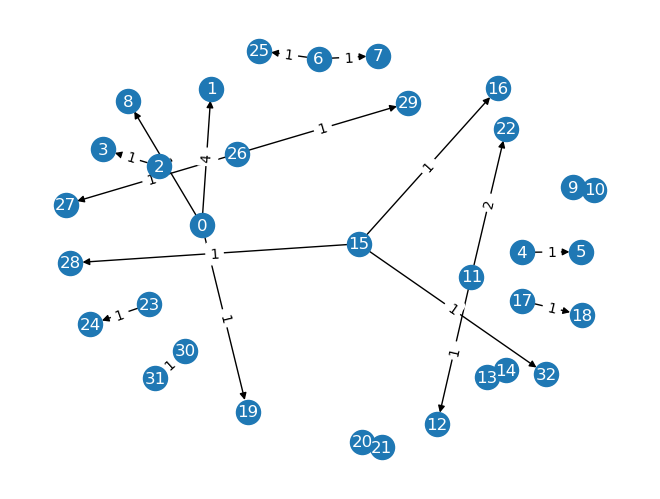

In [872]:
plt.figure()    
pos = nx.spring_layout(dg)
weight_labels = nx.get_edge_attributes(dg,'type')
nx.draw(dg,pos,font_color = 'white',  with_labels = True,)
nx.draw_networkx_edge_labels(dg,pos,edge_labels=weight_labels)

In [873]:
nx.dag_longest_path(dg)

[0, 1]

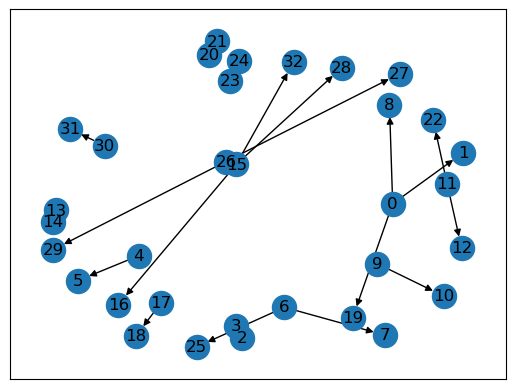

In [874]:
nx.draw_networkx(dsg)

In [875]:
# nx.write_gexf(G, 'graph_file1.gexf')

In [876]:
def subgraphs(i, G):
    sub_graph = {}
    sub_graphs = (G.subgraph(c) for c in nx.weakly_connected_components(G))
    for n, sg in enumerate(sub_graphs):
        sub_graph[n] = sg
    return sub_graph[i]
#     print ("subgraph {} has {} nodes".format(i, sg.number_of_nodes()))
#     print ("\tNodes:", sg.nodes(data=True))
#     print ("\tEdges:", sg.edges())

In [877]:
dg = graph()
first_node = p.min(list(dg.nodes()))
last_node = p.max(dg.nodes())
s_0 = subgraphs(source, dg)

In [878]:
nx.dag_longest_path(s_0)

[0, 1]

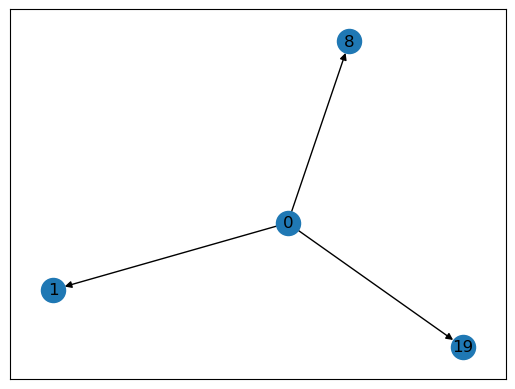

In [879]:
nx.draw_networkx(s_0)

In [880]:
def descendants(G, source):
    """Return all nodes reachable from `source` in G.
    Parameters
    ----------
    G : NetworkX DiGraph
    source : node in G
    Returns
    -------
    des : set()
        The descendants of source in G
    """
    if not G.has_node(source):
        raise nx.NetworkXError("The node %s is not in the graph." % source)
    des = set(nx.shortest_path_length(G, source=source).keys()) - set([source])
    return des

In [881]:
descendants(dg, source)

{1, 8, 19}

In [882]:
def ancestors(G, source):
    """Return all nodes having a path to `source` in G.
    Parameters
    ----------
    G : NetworkX DiGraph
    source : node in G
    Returns
    -------
    ancestors : set()
        The ancestors of source in G
    """
    if not G.has_node(source):
        raise nx.NetworkXError("The node %s is not in the graph." % source)
    anc = set(nx.shortest_path_length(G, target=source).keys()) - set([source])
    return anc

In [883]:
ancestors(dg,source)

set()

In [884]:
from graphframes.lib import AggregateMessages as AM
from pyspark.sql import functions as F

In [888]:
add_path_udf = F.udf(lambda path, id: path + [id], ArrayType(StringType()))
add_path_udf

<function __main__.<lambda>(path, id)>

<function __main__.<lambda>(path, id)>